## Lisence

In [31]:
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Modifications copyright 2020 Dennis Adelved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Imports

In [32]:

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
import matplotlib.pyplot as plt
from PIL import Image
import glob
import re

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

#if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  #raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


# This is needed to display the images.
%matplotlib inline
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [33]:
from utils import label_map_util
from utils import visualization_utils as vis_util

## Path Configuration

In [34]:
#Set the path to the folder containing the exported inference graph
MODEL_NAME = 'M2_inference_graph'

#adding the frozen inference graph to the path
PATH_TO_FROZEN_GRAPH = os.path.join(MODEL_NAME,'frozen_inference_graph.pb')

#Path to the label map
PATH_TO_LABELS = 'labelmap.pbtxt'

#Path to the images that are used for inference. Here only three sample images are given.
#However, more can be added to this directory
PATH_TO_TEST_IMAGES_DIR = 'images'

#The output directory for the cropped core images. If no cropping is desired set OUTPUT_DIR = None
OUTPUT_DIR = os.path.join('cropped_output')

## Load a (frozen) Tensorflow model into memory.

In [35]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [36]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [37]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [38]:
#Run inference on image using the frozen inference graph
def run_inference_for_single_image(image, graph):


    if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)


    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
    # Run inference
    output_dict = sess.run(tensor_dict,
                         feed_dict={image_tensor: image})

    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict[
      'detection_classes'][0].astype(np.int64)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [39]:

TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR,'*.jpg'))



#empty list for saving the output dicts for each prediction
dicts = []
IMAGE_SIZE = (20,20)

#SET TRUE IF THE PREDICTED BOUNDING BOXES SHALL BE VISUALIZED ON THE INPUT IMAGE
VISUALIZE = False


#Retrieve the detection data from the inference
with detection_graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)

        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.

            #image_np = load_image_into_numpy_array(image) #funker ikke for alle typer input graph

            a = np.asarray(image)
            image_np = np.copy(a[:,:,0:3])



            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            # Actual detection.
            output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)  
            
            #append detection from image to the detection list
            dicts.append(output_dict)
            
            # Visualization of the results of a detection. 
            #(comment out this block if the visualization slows down the running time of the script)
            if VISUALIZE==True:
                vis_util.visualize_boxes_and_labels_on_image_array(
                  image_np,
                  output_dict['detection_boxes'],
                  output_dict['detection_classes'],
                  output_dict['detection_scores'],
                  category_index,
                  instance_masks=output_dict.get('detection_masks'),
                  use_normalized_coordinates=True,
                  line_thickness=12)
                plt.figure(figsize=IMAGE_SIZE)
                plt.imshow(image_np)


## Post-Processing Functions

In [46]:
#Denormalize the bounding box coordinates generated by the model
def denormalize(array,image):
    denorm = array.copy()
    h,w = im.shape[0:2]
    for i in range(array.shape[0]):
        ymin = int(array[i][0][0]*h);
        xmin = int(array[i][0][1]*w)
        ymax = int(array[i][0][2]*h)
        xmax = int(array[i][0][3]*w)
        #print(xmin,':',ymin,':',xmax,':',ymax)
        denorm[i] = xmin,ymin,xmax,ymax
    return denorm

#non-max supression function (remove overlaping bounding boxes)
def non_max_supression(boxes,overlapThresh):
    if len(boxes) == 0:
        return []
    
    pick = []
    xmin = boxes[:,0]
    ymin = boxes[:,1]
    xmax = boxes[:,2]
    ymax = boxes[:,3]
    area = (xmax - xmin + 1) * (ymax - ymin + 1)
    idxs = np.argsort(ymax)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        xxmin = np.maximum(xmin[i], xmin[idxs[:last]])
        yymin = np.maximum(ymin[i], ymin[idxs[:last]])
        xxmax = np.minimum(xmax[i], xmax[idxs[:last]])
        yymax = np.minimum(ymax[i], ymax[idxs[:last]])
        
        w = np.maximum(0, xxmax - xxmin + 1)
        h = np.maximum(0, yymax - yymin + 1)
 

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")
    
#returns the filename and file extension from the path
def get_filename(path):
    filename = re.findall('^(.+)/([^/]+)$',path)
    filename = filename[0][1].split('.')
    return filename

def merge_same_col(b): 
    test = b[b[:,2].argsort()]
    i = np.argwhere(abs(np.diff(test[:,2])) < 10)
    samecoreind = np.argwhere(abs(test[:,2] - test[:,2][i])< 10)[:,-1]
    if len(samecoreind) == 0:
        return b
    else:
        
        samecore = test[samecoreind,:]
        top = samecore[np.argwhere(samecore[:,1] == min(samecore[:,1])),1]
        base = samecore[np.argwhere(samecore[:,-1] == max(samecore[:,-1])),-1]
        newrow = samecore[0]
        newrow[1] = top
        newrow[-1] = base
        test = np.delete(test,samecoreind,axis=0)
        return np.vstack((test,newrow))
    

In [42]:
dicts

[{'num_detections': 100,
  'detection_boxes': array([[0.11523836, 0.26890582, 0.91858125, 0.40764534],
         [0.10672367, 0.7694244 , 0.8996606 , 0.9050274 ],
         [0.10580255, 0.6022952 , 0.89912945, 0.7404996 ],
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]], dtype=float32),
  'detection_scores': array([9.99358594e-01, 9.99327183e-01, 9.99276102e-01, 9.99265134e-01,
         9.96338725e-01, 2.16969798e-04, 9.66244406e-05, 9.24116102e-05,
         5.65095725e-05, 1.91191430e-05, 3.36708308e-06, 3.04347077e-06,
         2.57889997e-06, 1.02253728e-06, 6.95085816e-07, 6.61479305e-07,
         2.03678852e-07, 1.72456936e-07, 1.62564220e-07, 1.09334010e-07,
         1.01930723e-07, 9.62775388e-08, 9.58595763e-08, 6.66436009e-08,
         5.16441609e-08, 2.64566644e-08, 1.33325093e-08, 1.32728326e-08,
         1.08644640e-08, 9.79187043e-09,

## Cropping

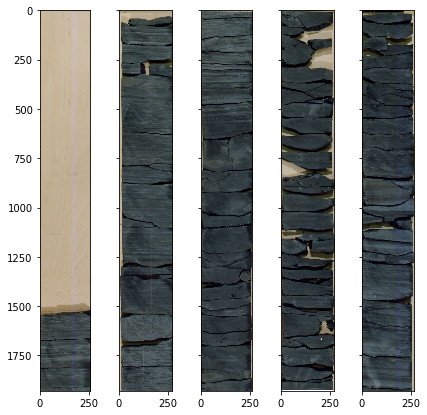

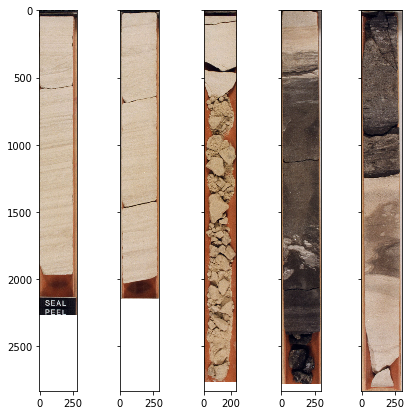

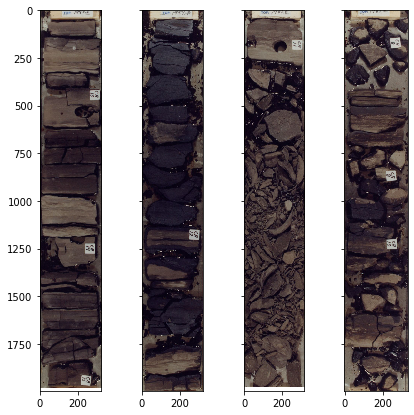

In [47]:
#zipping the image paths and output_dicts for paralell iteration
zipped = list(zip(TEST_IMAGE_PATHS,dicts))




for i in range(len(zipped)):
    #extract only the bounding boxes of the predictions with a high detection score
    ind = np.argwhere(zipped[i][1]['detection_scores']>.8)

    arr = zipped[i][1]['detection_boxes'][ind].copy()
    
    
    filename = get_filename(zipped[i][0])
    #open the image, normalize the bounding box coordiantes and apply non-max supression
    im = Image.open(zipped[i][0])
    im = np.array(im)
    b = denormalize(arr,im)
    mintop = min(np.squeeze(b)[:,1]) 
    b = b.reshape(b.shape[0],b.shape[2])
    
    boxes = non_max_supression(b,0.5)

    #display the cropped result
    boxes = merge_same_col(boxes)
    col=len(boxes); row=1
    fig, axs = plt.subplots(row, col, figsize=(7, 7),sharey=True)
    for i in range(col):
        bb = boxes[boxes[:,0].argsort()][i]
        if bb[1] > mintop:
            bb[1] = mintop
        axs[i].imshow(im[int(bb[1]):int(bb[3]),int(bb[0]):int(bb[2])])
        
        #saving the cropped images
        if OUTPUT_DIR != None:
            filename_new = filename[0] + '_core_' + str(i) + '.' + filename[1]
            plt.imsave(os.path.join(OUTPUT_DIR,filename_new), im[int(bb[1]):int(bb[3]),int(bb[0]):int(bb[2])] )
            
